# 장애인 콜택시 대기시간 예측 프로젝트 데이터 처리
## 목표
- 기상 예보를 바탕으로, 장애인 콜택시 평균 대기 시간을 예측하기.
- 장애인 이동권 개선을 위하여서, 콜택시 대기시간을 예측하는 프로젝트이다.  
- 이를 통하여 장애인 콜택시를 이용하는 고객들의 불편사항을 개선하고 서비스의 품질을 높여 교통약자의 이동 편의 증진에 기여한다.
### 목차
1. 데이터 처리  
2. 데이터 분석
3. **머신러닝 모델링**   
    - (나머지 3달 데이터는 테스트, 나머지는 학습데이터로 활용)  
    - MAE, MAPE를 사용해 성능 높은 모델 선정  
- 데이터 출처 : [서울시설공단_장애인콜택시 일별 이용현황](https://www.data.go.kr/data/15057705/openapi.do)  

## 라이브러리 불러오기

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 회귀 모델
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 회귀 성능 튜닝
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# 회귀 평가
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score

# 딥러닝
import tensorflow as tf

import warnings
warnings.filterwarnings(action='ignore') # pd 경고메시지 생략

## 데이터 불러오기

In [44]:
# df = pd.read_csv('./data/df.csv')
df = joblib.load('./data/df.pkl')
df.head()

,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,target,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),year,month,week,weekday,holiday,7days_waiting_time
time,,,,,,,,,,,,,,,,,,,
2015-01-01,213,1023,924,23.2,2427,10764,17.2,-2.0,-8.9,0.0,63.0,28.0,9.07,2015,1,1,3,1.0,NaN
2015-01-02,420,3158,2839,17.2,2216,8611,26.2,2.4,-9.2,0.0,73.0,37.0,8.66,2015,1,1,4,0.0,NaN
2015-01-03,209,1648,1514,26.2,2377,10198,24.5,8.2,0.2,0.0,89.0,58.0,5.32,2015,1,1,5,1.0,NaN
2015-01-04,196,1646,1526,24.5,2431,10955,26.2,7.9,-0.9,0.0,95.0,52.0,6.48,2015,1,1,6,1.0,NaN
2015-01-05,421,4250,3730,26.2,2214,8663,23.6,4.1,-7.4,3.4,98.0,29.0,10.47,2015,1,2,0,0.0,NaN


#### NaN 값 처리, 타입 변경하기

In [45]:
drop_col = '7days_waiting_time'
df = df.drop(drop_col, axis=1)

In [46]:
df

,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,target,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),year,month,week,weekday,holiday
time,,,,,,,,,,,,,,,,,,
2015-01-01,213,1023,924,23.2,2427,10764,17.2,-2.0,-8.9,0.0,63.0,28.0,9.07,2015,1,1,3,1.0
2015-01-02,420,3158,2839,17.2,2216,8611,26.2,2.4,-9.2,0.0,73.0,37.0,8.66,2015,1,1,4,0.0
2015-01-03,209,1648,1514,26.2,2377,10198,24.5,8.2,0.2,0.0,89.0,58.0,5.32,2015,1,1,5,1.0
2015-01-04,196,1646,1526,24.5,2431,10955,26.2,7.9,-0.9,0.0,95.0,52.0,6.48,2015,1,1,6,1.0
2015-01-05,421,4250,3730,26.2,2214,8663,23.6,4.1,-7.4,3.4,98.0,29.0,10.47,2015,1,2,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,669,5635,4654,44.4,2198,8178,44.8,-0.3,-5.4,0.1,92.0,40.0,10.86,2022,12,52,1,0.0
2022-12-28,607,5654,4648,44.8,2161,7882,52.5,1.7,-7.8,0.0,71.0,34.0,10.88,2022,12,52,2,0.0
2022-12-29,581,5250,4247,52.5,2229,8433,38.3,2.1,-4.0,0.0,87.0,38.0,10.84,2022,12,52,3,0.0


# 데이터 나누기
* 시계열 데이터 특성에 맞게 분할  
* 마지막 91일(3개월) 데이터를 검증셋으로 사용

#### x,y 분리하기

In [47]:
target = 'target'

x = df.drop(target, axis=1)
y = df.loc[:,target]

#### 가변수화

In [48]:
# 가변수화
dumm_cols = ['year','month','week','weekday','holiday']
x = pd.get_dummies(x, columns=dumm_cols, drop_first=True)

In [50]:
display(x.head(2))
display(y.head(2))

,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,temp_max,temp_min,rain(mm),humidity_max(%),...,week_51,week_52,week_53,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,holiday_1.0
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01,213,1023,924,23.2,2427,10764,-2.0,-8.9,0.0,63.0,...,0,0,0,0,0,1,0,0,0,1
2015-01-02,420,3158,2839,17.2,2216,8611,2.4,-9.2,0.0,73.0,...,0,0,0,0,0,0,1,0,0,0


time
2015-01-01    17.2
2015-01-02    26.2
Name: target, dtype: float64

In [51]:
y.head(2)

time
2015-01-01    17.2
2015-01-02    26.2
Name: target, dtype: float64

#### train, validation 나누기

In [52]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 92, shuffle=False)

In [53]:
x_train

,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,temp_max,temp_min,rain(mm),humidity_max(%),...,week_51,week_52,week_53,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,holiday_1.0
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01,213,1023,924,23.2,2427,10764,-2.0,-8.9,0.0,63.0,...,0,0,0,0,0,1,0,0,0,1
2015-01-02,420,3158,2839,17.2,2216,8611,2.4,-9.2,0.0,73.0,...,0,0,0,0,0,0,1,0,0,0
2015-01-03,209,1648,1514,26.2,2377,10198,8.2,0.2,0.0,89.0,...,0,0,0,0,0,0,0,1,0,1
2015-01-04,196,1646,1526,24.5,2431,10955,7.9,-0.9,0.0,95.0,...,0,0,0,0,0,0,0,0,1,1
2015-01-05,421,4250,3730,26.2,2214,8663,4.1,-7.4,3.4,98.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,642,5947,5039,45.5,2236,8529,27.7,14.1,0.0,86.0,...,0,0,0,0,0,0,0,0,0,0
2022-09-27,667,6044,5087,43.6,2238,8585,25.8,16.3,0.0,84.0,...,0,0,0,1,0,0,0,0,0,0
2022-09-28,670,6182,5176,44.7,2258,8751,26.3,16.5,0.0,92.0,...,0,0,0,0,1,0,0,0,0,0


#### 정규화
- knn 사용을 위해서

In [54]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_s = scaler.transform(x_train)
x_test_s = scaler.transform(x_train)

# 데이터 모델링

- MAE, MAPE로 성능 측정
- MAE와 MAPE는 모두 값이 작을수록 모델의 성능이 좋다는 것을 의미한다.

## ML

#### ML모델 선언

In [55]:
LR_model = LinearRegression()
KN_model = KNeighborsRegressor()
Tree_model = DecisionTreeRegressor()
RanF_model = RandomForestRegressor()
xg_model = XGBRegressor()
lg_model = LGBMRegressor()

models = {'LR_model':LR_model,
        'KN_model':KN_model,
        'Tree_model':Tree_model,
        'RanF_model':RanF_model,
        'xg_model':xg_model,
        'lg_model':lg_model}

#### 모델 학습 및 평가

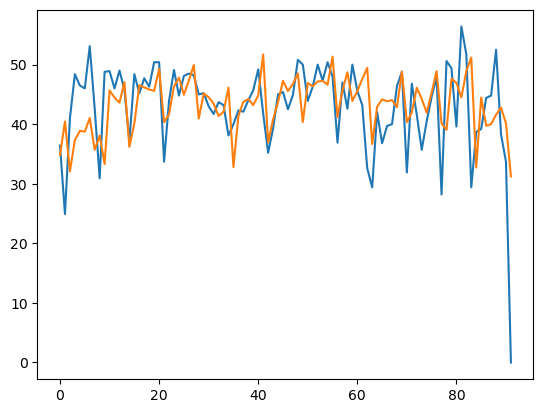

LR_model
MAE: 5.053185285322601
MAPE: 1529340416739568.2
r2: 0.11249606583044691


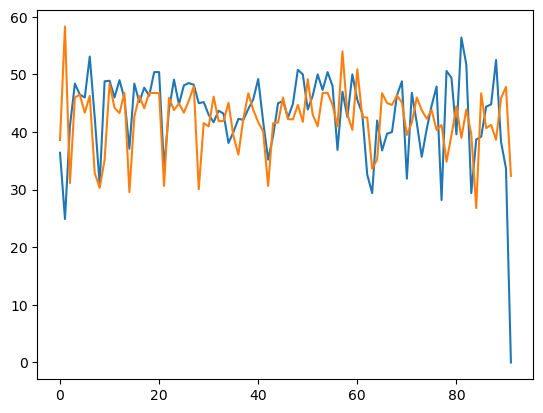

KN_model
MAE: 5.69891304347826
MAPE: 1585071260154963.5
r2: -0.13905171772709735


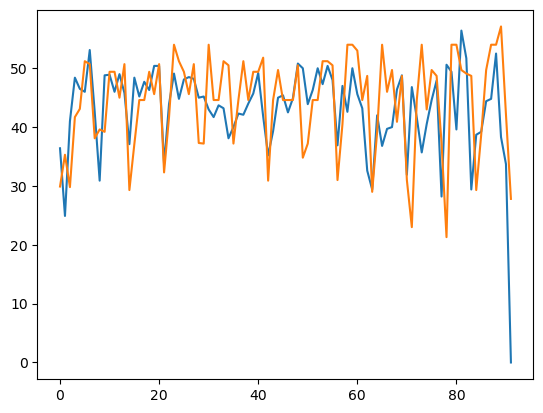

Tree_model
MAE: 6.343478260869563
MAPE: 1360870322183693.5
r2: -0.3232222488857768


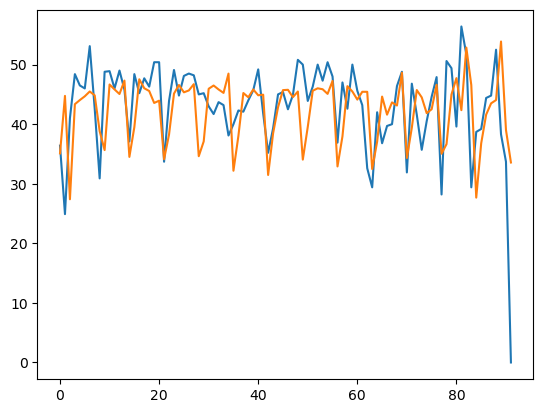

RanF_model
MAE: 5.213739130434784
MAPE: 1643275390121743.0
r2: 0.044408730910500904


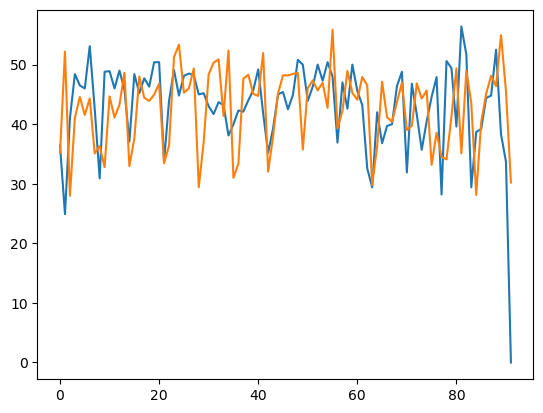

xg_model
MAE: 6.554809989099915
MAPE: 1478645477494250.0
r2: -0.29366087363553617
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2717
[LightGBM] [Info] Number of data points in the train set: 2831, number of used features: 88
[LightGBM] [Info] Start training from score 40.202614


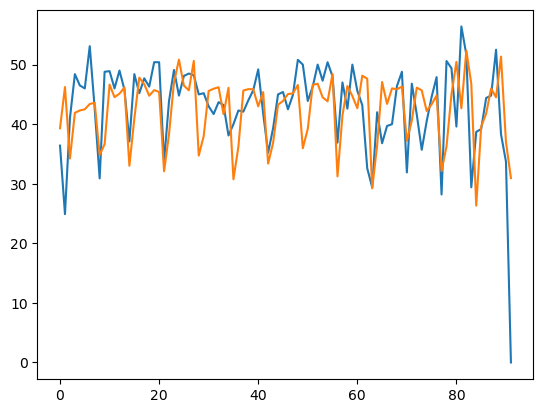

lg_model
MAE: 5.251531819592938
MAPE: 1515122737262632.8
r2: 0.08339720036267806


In [56]:
results = []
for name, model in models.items():
    print("="*50)
    if model != 'KN_model':
        model.fit(x_train, y_train) # 모델 학습
        y_pred = model.predict(x_test) # 모델 예측
        model_mae = mae(y_test, y_pred)
        model_mape = mape(y_test, y_pred)
        model_r2 = r2_score(y_test, y_pred)
    else:
        model.fit(x_train_s, y_train)
        y_pred = model.predict(x_test_s)
        model_mae = mae(y_test, y_pred)
        model_mape = mape(y_test, y_pred)
        model_r2 = r2_score(y_test, y_pred)
        
    plt.plot(np.array(y_test))
    plt.plot(y_pred)
    plt.show()
    print(name)
    print('MAE:', model_mae)
    print('MAPE:', model_mape)
    print('r2:', model_r2)
    
    results.append([name, (model_mae, model_mape, model_r2)])

In [57]:
sorted(results, key=lambda x: x[1][2])

[['Tree_model', (6.343478260869563, 1360870322183693.5, -0.3232222488857768)],
 ['xg_model', (6.554809989099915, 1478645477494250.0, -0.29366087363553617)],
 ['KN_model', (5.69891304347826, 1585071260154963.5, -0.13905171772709735)],
 ['RanF_model', (5.213739130434784, 1643275390121743.0, 0.044408730910500904)],
 ['lg_model', (5.251531819592938, 1515122737262632.8, 0.08339720036267806)],
 ['LR_model', (5.053185285322601, 1529340416739568.2, 0.11249606583044691)]]

#### 모델 튜닝
- 해당부분, 공유를 통하여 문제 해결하면 좋을것 같다는 생각함

##### KNN 모델

In [58]:
# 파라미터 선언
param = {'n_neighbors': range(1, 500, 10),
        'metric': ['euclidean', 'manhattan']}

# Random Search 선언
model = GridSearchCV(KN_model,
                            param,
                            cv=3)
# 학습하기
model.fit(x_train_s, y_train)

# 중요 정보 확인
print('=' * 80)
print(model.cv_results_['mean_test_score'])
print('-' * 80)
print('최적파라미터:', model.best_params_)
print('-' * 80)
print('최고성능:', model.best_score_)
print('=' * 80)

# 예측하기
y_pred = model.predict(x_test_s)

[-1.52235478 -0.88896438 -0.87109939 -0.90881878 -0.9410595  -0.93019751
 -0.89503508 -0.86050098 -0.8324495  -0.81673354 -0.81366624 -0.81300661
 -0.8136486  -0.8197963  -0.82507975 -0.83121749 -0.83560962 -0.84208577
 -0.85213264 -0.8625893  -0.8739141  -0.88709997 -0.90147841 -0.91408078
 -0.92846884 -0.94220529 -0.95699315 -0.97109813 -0.98510415 -0.99848866
 -1.0120935  -1.024471   -1.03677627 -1.04708007 -1.05674369 -1.06245436
 -1.06746958 -1.07121498 -1.07305304 -1.07482831 -1.07776315 -1.08157968
 -1.08521936 -1.08683529 -1.08843829 -1.08950805 -1.08851889 -1.08756694
 -1.08598357 -1.08410111 -1.65419056 -0.92455258 -0.89494307 -0.93196076
 -0.93934463 -0.9140162  -0.88083806 -0.85614377 -0.84050682 -0.83136742
 -0.82626589 -0.82539397 -0.82647513 -0.82936001 -0.83712747 -0.84301525
 -0.85108565 -0.85882161 -0.86875313 -0.88076327 -0.89310334 -0.90434664
 -0.9157454  -0.9273465  -0.9393616  -0.9506523  -0.96157456 -0.97246665
 -0.98152008 -0.98925594 -0.99768621 -1.00479685 -1

##### RandomForest 모델

In [59]:
# 파라미터 선언
# max_depth: 1~50
param = {'max_depth': range(1,51)}

# Random Search 선언
  # cv=5
  # n_iter=20
  # scoring='r2'
model = RandomizedSearchCV(RanF_model, # 기본 모델
                          param,       # 파라미터 범위
                          cv=5,        # K-Folde 개수
                          n_iter=20   # 랜덤하게 선택할 파라미터(조합) 개수
                          )
# 학습하기
model.fit(x_train, y_train)

# 중요 정보 확인
print('=' * 80)
print(model.cv_results_['mean_test_score'])
print('-' * 80)
print('최적파라미터:', model.best_params_)
print('-' * 80)
print('최고성능:', model.best_score_)
print('=' * 80)

# 예측하기
y_pred = model.predict(x_test)

print('MAE:', mae(y_test, y_pred))
print('MAPE:', mape(y_test, y_pred))
print('r2:', r2_score(y_test, y_pred))

[0.29763339 0.28598587 0.28486594 0.29380599 0.12755313 0.29814871
 0.28642638 0.2930161  0.27563949 0.29078289 0.29501131 0.28496968
 0.29544646 0.2835459  0.2867176  0.29591158 0.28635417 0.29697337
 0.29432154 0.27697779]
--------------------------------------------------------------------------------
최적파라미터: {'max_depth': 16}
--------------------------------------------------------------------------------
최고성능: 0.2981487066609032
MAE: 5.261799935582116
MAPE: 1580883707974270.5
r2: 0.05124200923942235


##### Decision Tree 모델

In [60]:
# 파라미터 선언
# max_depth: 1~50
param = {'max_depth': range(1,51)}

model = RandomizedSearchCV(Tree_model, # 기본 모델
                          param,       # 파라미터 범위
                          cv=5,        # K-Folde 개수
                          n_iter=20   # 랜덤하게 선택할 파라미터(조합) 개수
                          )
# 학습하기
model.fit(x_train, y_train)

# 중요 정보 확인
print('=' * 80)
print(model.cv_results_['mean_test_score'])
print('-' * 80)
print('최적파라미터:', model.best_params_)
print('-' * 80)
print('최고성능:', model.best_score_)
print('=' * 80)

# 예측하기
y_pred = model.predict(x_test)

print('MAE:', mae(y_test, y_pred))
print('MAPE:', mape(y_test, y_pred))
print('r2:', r2_score(y_test, y_pred))

[-0.28837002 -0.33567132 -0.37513716 -0.32111788 -0.40535513 -0.34724133
 -0.32959849 -0.34215413 -0.26339956  0.03581485 -0.24520748  0.09297604
 -0.32157052 -0.31383972 -0.34102029 -0.28028403 -0.33213031 -0.29611346
 -0.01187636 -0.22695853]
--------------------------------------------------------------------------------
최적파라미터: {'max_depth': 2}
--------------------------------------------------------------------------------
최고성능: 0.09297604032300474
MAE: 6.041994067393407
MAPE: 1823921764071381.2
r2: -0.2416964036272653


## DeapLearning

In [61]:
print(f"X shape : {x_train.shape}")
print(f"Y shape : {y_train.shape}")

X shape : (2831, 89)
Y shape : (2831,)


#### 모델 구조 생성

In [64]:
X = tf.keras.Input(shape=[89])

# 은닉 레이어 
H = tf.keras.layers.Dense(256)(X)
H = tf.keras.layers.BatchNormalization()(H)
H = tf.keras.layers.Activation('swish')(H)

# 여기 부분이 skip connection 레이어층 쌓기 부분
for i in range(10):
    H1 = tf.keras.layers.Dropout(0.6)(H)
    H1 = tf.keras.layers.Dense(1024)(H1)
    H1 = tf.keras.layers.BatchNormalization()(H1)
    H1 = tf.keras.layers.Activation("ReLU")(H1)
    
    H1 = tf.keras.layers.Dropout(0.6)(H)
    H1 = tf.keras.layers.Dense(512)(H1)
    H1 = tf.keras.layers.BatchNormalization()(H1)
    H1 = tf.keras.layers.Activation("ReLU")(H1)
    
    H1 = tf.keras.layers.Dropout(0.6)(H1)
    H1 = tf.keras.layers.Dense(256)(H1)
    H1 = tf.keras.layers.BatchNormalization()(H1)
    H = tf.keras.layers.Add()([H,H1])
    H = tf.keras.layers.Activation("ReLU")(H)
Y = tf.keras.layers.Dense(1, activation="linear")(H)

dp_model = tf.keras.Model(X, Y)
dp_model.compile(loss=tf.keras.losses.mse, 
                 metrics=tf.keras.metrics.mae,
                optimizer = 'Adam')
dp_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 89)]                 0         []                            
                                                                                                  
 dense_121 (Dense)           (None, 256)                  23040     ['input_5[0][0]']             
                                                                                                  
 batch_normalization_117 (B  (None, 256)                  1024      ['dense_121[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 activation_117 (Activation  (None, 256)                  0         ['batch_normalization_11

 )                                                                                                
                                                                                                  
 dropout_90 (Dropout)        (None, 256)                  0         ['activation_126[0][0]']      
                                                                                                  
 dense_132 (Dense)           (None, 512)                  131584    ['dropout_90[0][0]']          
                                                                                                  
 batch_normalization_128 (B  (None, 512)                  2048      ['dense_132[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 activation_128 (Activation  (None, 512)                  0         ['batch_normalization_128[0][0
 )        

                                                                                                  
 dropout_100 (Dropout)       (None, 512)                  0         ['activation_137[0][0]']      
                                                                                                  
 dense_142 (Dense)           (None, 256)                  131328    ['dropout_100[0][0]']         
                                                                                                  
 batch_normalization_138 (B  (None, 256)                  1024      ['dense_142[0][0]']           
 atchNormalization)                                                                               
                                                                                                  
 add_68 (Add)                (None, 256)                  0         ['activation_135[0][0]',      
                                                                     'batch_normalization_138[0][0
          

                                                                                                  
 activation_147 (Activation  (None, 256)                  0         ['add_71[0][0]']              
 )                                                                                                
                                                                                                  
 dense_152 (Dense)           (None, 1)                    257       ['activation_147[0][0]']      
                                                                                                  
Total params: 2684161 (10.24 MB)
Trainable params: 2668289 (10.18 MB)
Non-trainable params: 15872 (62.00 KB)
__________________________________________________________________________________________________


#### 오버피팅 방지 및 모델 학습

In [65]:
# 콜백함수 만들기
early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                        min_delta = 0, # 이보다 작게 변하면 변한다고 안할거임.
                                        patience = 15, # 이 회수(epoch)동안 개선이 없으면 끝냄
                                        restore_best_weights=True)
# 모델 학습
result = dp_model.fit(x_train, y_train, epochs=1000, batch_size=32, validation_split=0.2, callbacks=[early])

Epoch 1/1000
71/71 [==============================] - 15s 60ms/step - loss: 636.0179 - mean_absolute_error: 19.8418 - val_loss: 1123.2391 - val_mean_absolute_error: 32.3072
Epoch 2/1000
71/71 [==============================] - 4s 50ms/step - loss: 168.3810 - mean_absolute_error: 10.0011 - val_loss: 154.1837 - val_mean_absolute_error: 10.0938
Epoch 3/1000
71/71 [==============================] - 4s 51ms/step - loss: 146.8528 - mean_absolute_error: 9.2483 - val_loss: 484.7961 - val_mean_absolute_error: 20.1913
Epoch 4/1000
71/71 [==============================] - 4s 53ms/step - loss: 145.1067 - mean_absolute_error: 9.1436 - val_loss: 681.6510 - val_mean_absolute_error: 21.9107
Epoch 5/1000
71/71 [==============================] - 4s 54ms/step - loss: 139.9196 - mean_absolute_error: 8.9801 - val_loss: 306.3139 - val_mean_absolute_error: 14.4078
Epoch 6/1000
71/71 [==============================] - 4s 52ms/step - loss: 133.1012 - mean_absolute_error: 8.7627 - val_loss: 336.2212 - val_mean_

In [66]:
# 모델 평가하기
dp_model.evaluate(x_test, y_test)

3/3 [==============================] - 0s 13ms/step - loss: 69.2204 - mean_absolute_error: 6.4253


[69.22041320800781, 6.425258636474609]

In [69]:
# 예측하기
y_pred = dp_model.predict(x_test)

print('MAE:', mae(y_test, y_pred))
print('MAPE:', mape(y_test, y_pred))
print('r2_score:', r2_score(y_test, y_pred))

3/3 [==============================] - 0s 12ms/step
MAE: 6.425258458178976
MAPE: 1333031894094002.2
r2_score: -0.21160949922296757


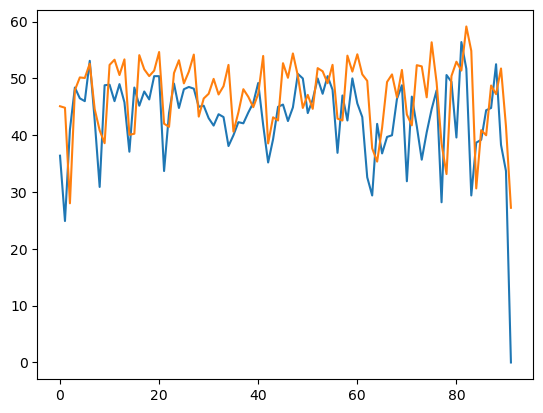

In [68]:
plt.plot(np.array(y_test))
plt.plot(y_pred)
plt.show()